In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/Shareddrives/group12 cs4824/code")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import numpy as np
import pandas as pd
# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
# Model
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Read Data from File

In [18]:
df = pd.read_csv("music_genre.csv")
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


# Removing Junk and Converting Data to Usable Values

Null values, duplicates, and unnecessary columns (instance_id and obtained_date) are all removed.
The mode and key are each converted into values by an encoder.

In [19]:
# Drop junk
df.dropna(axis=0, inplace=True)
df.drop_duplicates(subset = df.columns.difference(['music_genre']), inplace = True, ignore_index = True)
df.drop(columns=['instance_id','obtained_date'], inplace = True,axis=1)

In [20]:
# Convert to usable
df[['key','mode']] = OrdinalEncoder().fit_transform(df[['key','mode']])
df['tempo'].replace(to_replace = '?', value =-1.0, inplace=True)
df['instrumentalness'].replace(to_replace = 0.0, value =-1.0, inplace=True)
df['tempo'] = pd.to_numeric(df['tempo'])
imp = SimpleImputer(missing_values = -1.0, strategy = 'median')
df[['tempo','duration_ms','instrumentalness']] = imp.fit_transform(df[['tempo','duration_ms','instrumentalness']])

In [21]:
# Encode string values
#le = LabelEncoder()
#for col in encode:
#    df[col] = le.fit_transform(df[col])
# Remove encodable values
encode = ["artist_name","track_name"]
df.drop(columns=encode, inplace = True,axis=1)
df.head(5)

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,valence,music_genre
0,27.0,0.00468,0.652,227360.0,0.941,0.79200,1.0,0.115,-5.201,1.0,0.0748,100.889,0.759,Electronic
1,31.0,0.01270,0.622,218293.0,0.890,0.95000,5.0,0.124,-7.043,1.0,0.0300,115.002,0.531,Electronic
2,28.0,0.00306,0.620,215613.0,0.755,0.01180,11.0,0.534,-4.617,0.0,0.0345,127.994,0.333,Electronic
3,34.0,0.02540,0.774,166875.0,0.700,0.00253,4.0,0.157,-4.498,0.0,0.2390,128.014,0.270,Electronic
4,32.0,0.00465,0.638,222369.0,0.587,0.90900,9.0,0.157,-6.266,0.0,0.0413,145.036,0.323,Electronic


# Feature Selection

key         0.046255
liveness    0.051182
mode        0.013890
dtype: float64


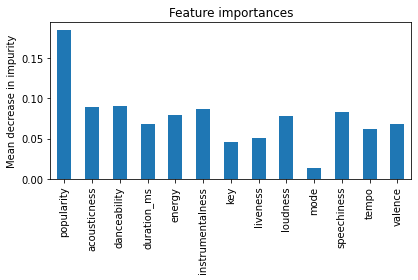

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
selector = ExtraTreesClassifier().fit(df.drop(columns=['music_genre'], axis=1), df['music_genre'])
importances = selector.feature_importances_

features = list(df.drop(columns=['music_genre'], axis=1).columns)
tree_importances = pd.Series(importances, index=features)
fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

print(tree_importances[tree_importances < 0.06])
df.drop(columns=(tree_importances[tree_importances < 0.06]).index, inplace = True,axis=1)

In [23]:
from sklearn.metrics.pairwise import pairwise_distances
X = df.loc[df['music_genre']=="Hip-Hop"].drop(columns=['music_genre'], axis=1)
Y = df.loc[df['music_genre']=="Rap"].drop(columns=['music_genre'], axis=1)
Z = df.loc[df['music_genre']=="Electronic"].drop(columns=['music_genre'], axis=1)
J = df.loc[df['music_genre']=="Alternative"].drop(columns=['music_genre'], axis=1)
L = df.loc[df['music_genre']=="Jazz"].drop(columns=['music_genre'], axis=1)
print("Average pairwise distance between Hip-Hop and Rap samples: " + str(np.average(pairwise_distances(X,Y))))
#print("Pairwise distance between Hip-Hop and Jazz: " + str(np.average(pairwise_distances(X,L))))
print("Average pairwise distance of Hip-Hop samples: " + str(np.average(pairwise_distances(X))))
print("Average pairwise distance of Rap samples: " + str(np.average(pairwise_distances(Y))))
print("Average pairwise distance between Hip-Hop and Electronic samples: " + str(np.average(pairwise_distances(X,Z))))
#print("Pairwise distance of Alternative: " + str(np.average(pairwise_distances(J))))
print("Pairwise distance of Electronic: " + str(np.average(pairwise_distances(Z))))
#print("Pairwise distance of Jazz: " + str(np.average(pairwise_distances(L))))

Average pairwise distance between Hip-Hop and Rap samples: 59333.64189442949
Average pairwise distance of Hip-Hop samples: 60715.158325436336
Average pairwise distance of Rap samples: 57896.83866021173
Average pairwise distance between Hip-Hop and Electronic samples: 85181.55532849296
Pairwise distance of Electronic: 98242.01685642193


# Set up Train and Test Data

In [24]:
#Prepare splits
dataTrain = df.sample(frac=0.7, random_state=1)    
dataTest = df.drop(dataTrain.index) 
X = df.drop(columns=['music_genre'], axis=1)
Y = df['music_genre']
X_train = dataTrain.drop(['music_genre'], axis=1).values
Y_train = dataTrain['music_genre'].values
X_test = dataTest.drop(['music_genre'], axis=1).values
Y_test = dataTest['music_genre'].values

# Decision Tree Classifier

Decision Tree accuracy is: 45.91%
Random Forest accuracy is: 54.93%


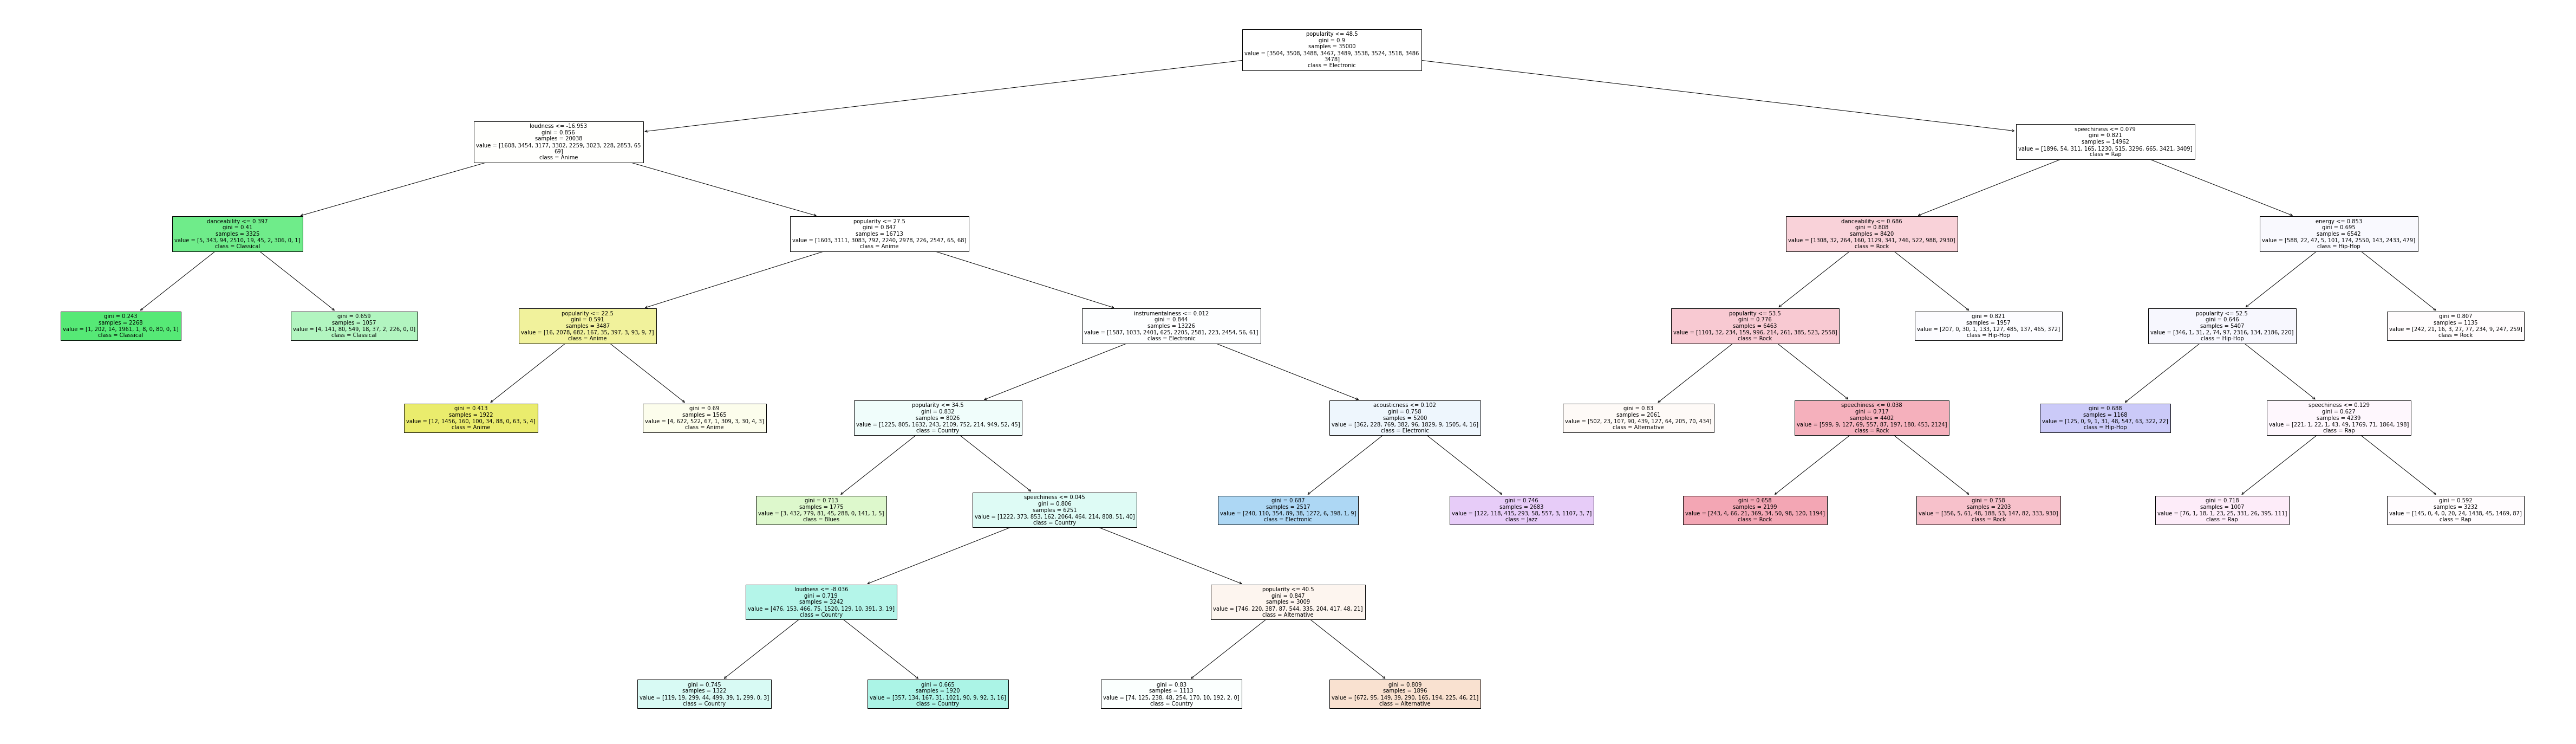

              precision    recall  f1-score   support

 Alternative       0.29      0.33      0.31      1496
       Anime       0.59      0.58      0.59      1492
       Blues       0.46      0.24      0.31      1512
   Classical       0.75      0.74      0.75      1533
     Country       0.42      0.50      0.46      1511
  Electronic       0.50      0.39      0.43      1462
     Hip-Hop       0.32      0.29      0.31      1476
        Jazz       0.40      0.29      0.34      1482
         Rap       0.45      0.53      0.49      1514
        Rock       0.43      0.68      0.52      1522

    accuracy                           0.46     15000
   macro avg       0.46      0.46      0.45     15000
weighted avg       0.46      0.46      0.45     15000



In [25]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Overfit
#DTclassifier = DecisionTreeClassifier().fit(X_train, Y_train)
# Intuitive Fit
#DTclassifier = DecisionTreeClassifier(min_samples_leaf=1000).fit(X_train, Y_train)
# Reduced Intuitive Fit
DTclassifier = DecisionTreeClassifier(min_samples_split=0.08,min_impurity_decrease=0.0005,min_samples_leaf=1000).fit(X_train, Y_train)
# Minimal Fit
#DTclassifier = DecisionTreeClassifier(min_impurity_decrease=0.01,min_samples_leaf=1000,max_leaf_nodes=30).fit(X_train, Y_train)
clf = RandomForestClassifier(min_impurity_decrease=0.0005).fit(X_train, Y_train)

rf_pred = clf.predict(X_test)
Y_pred = DTclassifier.predict(X_test)

DTAcc = accuracy_score(Y_pred,Y_test) # Calculating accuracy
RFAcc = accuracy_score(rf_pred,Y_test)
print('Decision Tree accuracy is: {:.2f}%'.format(DTAcc*100))
print('Random Forest accuracy is: {:.2f}%'.format(RFAcc*100))
plt.figure(figsize=(85,25))
tree.plot_tree(decision_tree=DTclassifier, feature_names=list(X.columns), filled=True, class_names=sorted(Y.unique()), fontsize=10)
plt.show()
print(classification_report(Y_test,Y_pred))

# Scale Data

In [39]:
scaler = StandardScaler()
data = df
data.iloc[:,:-1] = scaler.fit_transform(data.iloc[:,:-1].values)
data.head()

,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,loudness,speechiness,tempo,valence,music_genre
0,-1.108003,-0.883886,0.524878,-0.154369,1.289876,1.876078,0.638132,-0.185322,-0.655420,1.225073,Electronic
1,-0.850633,-0.860390,0.356933,-0.239968,1.097101,2.364033,0.339248,-0.627258,-0.170027,0.302431,Electronic
2,-1.043661,-0.888632,0.345737,-0.265269,0.586813,-0.533434,0.732892,-0.582867,0.276811,-0.498812,Electronic
3,-0.657606,-0.823184,1.207853,-0.725393,0.378918,-0.562063,0.752201,1.434452,0.277499,-0.753752,Electronic
4,-0.786291,-0.883974,0.446504,-0.201488,-0.048212,2.237412,0.465324,-0.515787,0.862942,-0.539278,Electronic


In [13]:
from sklearn.metrics.pairwise import pairwise_distances
X = data.loc[data['music_genre']=="Hip-Hop"].drop(columns=['music_genre'], axis=1)
Y = data.loc[data['music_genre']=="Rap"].drop(columns=['music_genre'], axis=1)
Z = data.loc[data['music_genre']=="Electronic"].drop(columns=['music_genre'], axis=1)
J = data.loc[data['music_genre']=="Alternative"].drop(columns=['music_genre'], axis=1)
L = data.loc[data['music_genre']=="Jazz"].drop(columns=['music_genre'], axis=1)
print("Average pairwise distance between Hip-Hop and Rap samples: " + str(np.average(pairwise_distances(X,Y))))
#print("Pairwise distance between Hip-Hop and Jazz: " + str(np.average(pairwise_distances(X,L))))
print("Average pairwise distance of Hip-Hop samples: " + str(np.average(pairwise_distances(X))))
print("Average pairwise distance of Rap samples: " + str(np.average(pairwise_distances(Y))))
print("Average pairwise distance between Hip-Hop and Electronic samples: " + str(np.average(pairwise_distances(X,Z))))
#print("Pairwise distance of Alternative: " + str(np.average(pairwise_distances(J))))
#print("Pairwise distance of Electronic: " + str(np.average(pairwise_distances(Z))))
#print("Pairwise distance of Jazz: " + str(np.average(pairwise_distances(L))))

Average pairwise distance between Hip-Hop and Rap samples: 3.155449239098457
Average pairwise distance of Hip-Hop samples: 3.1590881382150884
Average pairwise distance of Rap samples: 3.126771150425747
Average pairwise distance between Hip-Hop and Electronic samples: 4.005687133979616


In [40]:
#Prepare splits
dataTrain = data.sample(frac=0.7, random_state=1)    
dataTest = data.drop(dataTrain.index) 
xTrain = dataTrain.drop(['music_genre'], axis=1).values
yTrain = dataTrain['music_genre'].values
xTest = dataTest.drop(['music_genre'], axis=1).values
yTest = dataTest['music_genre'].values

# KNN

In [41]:
from sklearn.neighbors import KNeighborsClassifier
j=0
a=0
for i in list(range(1,50)):
  knn=KNeighborsClassifier(i).fit(xTrain,yTrain)
  score = knn.score(xTest, yTest)
  if score>j:
    j=score
    a=i
print(a)
print(j)
knn1=KNeighborsClassifier(a).fit(xTrain,yTrain)
knn1.fit(xTrain,yTrain)
pred = knn1.predict(xTest)

print(classification_report(yTest,pred))

35
0.5439333333333334
              precision    recall  f1-score   support

 Alternative       0.43      0.36      0.39      1496
       Anime       0.73      0.67      0.70      1492
       Blues       0.59      0.47      0.52      1512
   Classical       0.79      0.86      0.83      1533
     Country       0.44      0.59      0.50      1511
  Electronic       0.65      0.55      0.60      1462
     Hip-Hop       0.41      0.50      0.45      1476
        Jazz       0.51      0.45      0.48      1482
         Rap       0.43      0.33      0.38      1514
        Rock       0.50      0.64      0.56      1522

    accuracy                           0.54     15000
   macro avg       0.55      0.54      0.54     15000
weighted avg       0.55      0.54      0.54     15000



# SVM

In [42]:
from sklearn import svm
clfsvm = svm.SVC(decision_function_shape='ovo', kernel = 'rbf', C=5)
clfsvm.fit(xTrain, yTrain)
clfsvm.score(xTest, yTest)

0.5829333333333333

# NN

In [43]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam',hidden_layer_sizes=(150, 10), random_state=1, max_iter=800)
clf.fit(xTrain,yTrain)
clf.score(xTest,yTest)

0.5794

# Grab Values to Predict

In [ ]:
pip install spotipy --upgrade

     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 138 kB 23.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
cid = '10f92907722c44d5a24ed6486e961379'
secret = 'b1c12d2638ed4996a4b72ab313f49f1b'
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret)
sp = spotipy.Spotify(client_credentials_manager
=
client_credentials_manager)

In [ ]:
artist= input("Enter artist name: ")
track= input("Enter track name: ")

found = sp.search(q='artist:' + artist + ' track:' + track, type='track')
trackId = found['tracks']['items'][0]['id']

audio_features = sp.audio_features(trackId)[0]
sample = pd.DataFrame.from_dict([audio_features])
df_sample = df.median(numeric_only=True)

df_sample['popularity'] = found['tracks']['items'][0]['popularity']
df_sample['danceability'] = sample['danceability'].values[0]
df_sample['energy'] = sample['energy'].values[0]
df_sample['loudness'] = sample['loudness'].values[0]
df_sample['speechiness'] = sample['speechiness'].values[0]
df_sample['acousticness'] = sample['acousticness'].values[0]
df_sample['instrumentalness'] = sample['instrumentalness'].values[0]
df_sample['valence'] = sample['valence'].values[0]
df_sample['tempo'] = sample['tempo'].values[0]
df_sample['duration_ms'] = sample['duration_ms'].values[0]

# Example if Spotify API doesn't work
#artist = "Gorillaz"
#track = "Feel Good Inc"
#df_sample = [82.000000,0.008360,0.818000,222640.000000,0.705000,0.002330,-0.420059,-6.679000,0.177000,138.559000,0.772000]

print("Decision Tree Predicted Genre: ",DTclassifier.predict([df_sample])[0])
df_sample = scaler.transform([df_sample])
print("KNN Predicted Genre: ",knn1.predict(df_sample)[0])
print("SVM Predicted Genre: ",clfsvm.predict(df_sample)[0])
print("NN Predicted Genre: ",clf.predict(df_sample)[0])

Enter artist name: Eminem
Enter track name: Rap God
Decision Tree Predicted Genre:  Hip-Hop
KNN Predicted Genre:  Hip-Hop
SVM Predicted Genre:  Hip-Hop
NN Predicted Genre:  Hip-Hop
